### V. Feature Selection, Algorithm improvement, Generalization demo.

In this part, we create a model, we try different algorithms and see which one delivers the best results. Then we chose the best algorithm and fine tune it. 

This notebook presents the following parts:

    1) Model creation
    2) Feature Selection (hybrid method)
    3) Algorithm testing
        - verify reduce dataset gives goods results
    4) Improve the model (fine tune hyperparameters)
        - verify improved model delivers a better metric
    5) Save Model for inference
    6) Show evidence the new model will generalize well

In [1]:
# import libraries
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import roc_auc_score, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.feature_selection import f_classif, f_regression
from sklearn.metrics import mean_squared_log_error



%matplotlib inline
%matplotlib inline

In [2]:
#import data set
df=pd.read_csv('dftobeimproved.csv')
df.shape

(1399, 18)

In [3]:
df.head(2)

,capacity,failure_rate,margin,price,prod_cost,product_type:_auto-portee,product_type:_electrique,product_type:_essence,Quality:_Basic,Quality:_High,Quality:_Medium,Warranty_years:_1,Warranty_years:_2,Warranty_years:_3,Perc_Margin:_High,Perc_Margin:_Low,Perc_Margin:_Medium,attractiveness
0,-1.873473,-1.683579,2.342817,2.187839,0.911872,1,0,0,1,0,0,0,0,1,0,0,1,0.650648
1,-1.380486,-1.746504,2.854882,2.395929,0.583018,1,0,0,1,0,0,0,0,1,0,0,1,0.699792


**1) Model Creation**

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['attractiveness'], axis=1),
    df['attractiveness'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((979, 17), (420, 17))

In [5]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

**2) Features Selection (hybrid method:Hybrid recursive feature addition)**

From the previous notebook I know the best model is the Random Forest, so I create a hybrid method to select the best features for this algorithm. 

In [6]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = RandomForestRegressor()

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features rdf R2 = %f' % (r2_score_all))

Test all features rdf R2 = 0.624680


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


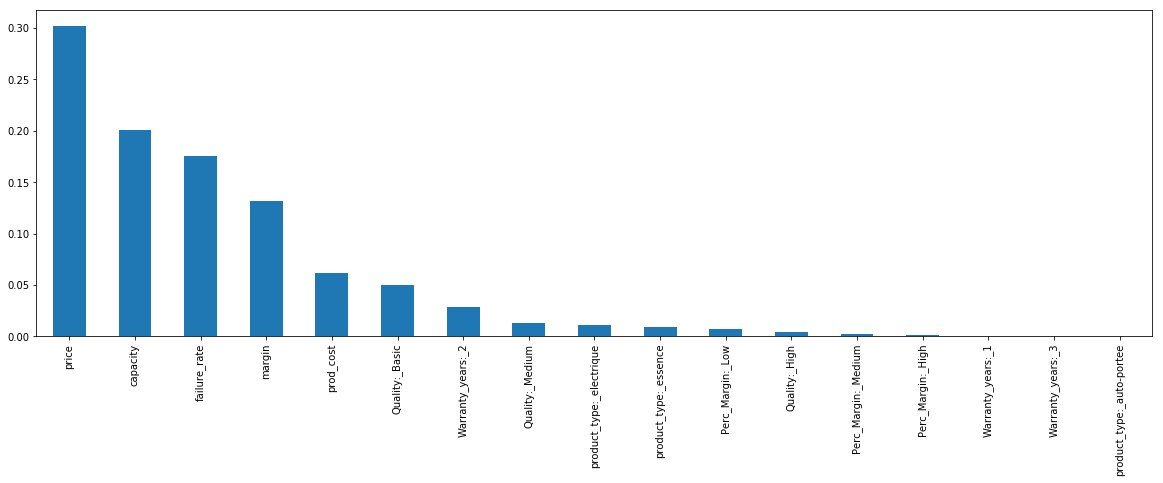

In [7]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['price',
 'capacity',
 'failure_rate',
 'margin',
 'prod_cost',
 'Quality:_Basic',
 'Warranty_years:_2',
 'Quality:_Medium',
 'product_type:_electrique',
 'product_type:_essence',
 'Perc_Margin:_Low',
 'Quality:_High',
 'Perc_Margin:_Medium',
 'Perc_Margin:_High',
 'Warranty_years:_1',
 'Warranty_years:_3',
 'product_type:_auto-portee']

In [9]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = RandomForestRegressor()

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
r2_score_first = r2_score(y_test, y_pred_test)
print('Test one feature RandomForest R2=%f' % (r2_score_first))

Test one feature xgb R2=0.170302


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new r2
# if the new r2 is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in r2
# if the increase is above this threshold,
# the feature will be kept
tol = 0.0015

print('Doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = RandomForestRegressor()

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test[features_to_keep + [feature] ])

    # calculate the new r2
    r2_score_int = r2_score(y_test, y_pred_test)
    print('New Test R2={}'.format((r2_score_int)))

    # print the original roc-auc with all the features
    print('All features Test R2={}'.format((r2_score_first)))

    # determine the drop in the roc-auc
    diff_r2 = r2_score_int - r2_score_first

    # compare the increase in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Increase in r2 = {}'.format(diff_r2))
        print('keep: ', feature)
        print
        # if the increase in the r2 is bigger than the threshold
        # we keep the feature and re-adjust the r2 to the new value
        # considering the added feature
        r2_score_first = r2_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  capacity  which is feature  1  out of  17
New Test R2=0.4939516039019033
All features Test R2=0.17030161034985858
Increase in r2 = 0.3236499935520447
keep:  capacity

testing feature:  failure_rate  which is feature  2  out of  17
New Test R2=0.5206390397988598
All features Test R2=0.4939516039019033
Increase in r2 = 0.026687435896956546
keep:  failure_rate

testing feature:  margin  which is feature  3  out of  17
New Test R2=0.5338240882608579
All features Test R2=0.5206390397988598
Increase in r2 = 0.013185048461998083
keep:  margin

testing feature:  prod_cost  which is feature  4  out of  17
New Test R2=0.5329052775135716
All features Test R2=0.5338240882608579
Increase in r2 = -0.0009188107472862805
remove:  prod_cost

testing feature:  Quality:_Basic  which is feature  5  out of  17


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test R2=0.6130496931289031
All features Test R2=0.5338240882608579
Increase in r2 = 0.0792256048680452
keep:  Quality:_Basic

testing feature:  Warranty_years:_2  which is feature  6  out of  17
New Test R2=0.6258704361119496
All features Test R2=0.6130496931289031
Increase in r2 = 0.012820742983046474
keep:  Warranty_years:_2

testing feature:  Quality:_Medium  which is feature  7  out of  17
New Test R2=0.6363864275405573
All features Test R2=0.6258704361119496
Increase in r2 = 0.010515991428607707
keep:  Quality:_Medium

testing feature:  product_type:_electrique  which is feature  8  out of  17
New Test R2=0.6313533828794933
All features Test R2=0.6363864275405573
Increase in r2 = -0.005033044661064023
remove:  product_type:_electrique

testing feature:  product_type:_essence  which is feature  9  out of  17
New Test R2=0.6295962434930453
All features Test R2=0.6363864275405573
Increase in r2 = -0.006790184047511971
remove:  product_type:_essence

testing feature:  Perc_Margin:

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test R2=0.6497601076583887
All features Test R2=0.6363864275405573
Increase in r2 = 0.013373680117831355
keep:  Perc_Margin:_Low

testing feature:  Quality:_High  which is feature  11  out of  17
New Test R2=0.6456704302065137
All features Test R2=0.6497601076583887
Increase in r2 = -0.00408967745187494
remove:  Quality:_High

testing feature:  Perc_Margin:_Medium  which is feature  12  out of  17
New Test R2=0.6266420691636434
All features Test R2=0.6497601076583887
Increase in r2 = -0.023118038494745252
remove:  Perc_Margin:_Medium

testing feature:  Perc_Margin:_High  which is feature  13  out of  17
New Test R2=0.6372517969518969
All features Test R2=0.6497601076583887
Increase in r2 = -0.012508310706491721
remove:  Perc_Margin:_High

testing feature:  Warranty_years:_1  which is feature  14  out of  17
New Test R2=0.6120705666916211
All features Test R2=0.6497601076583887
Increase in r2 = -0.037689540966767576
remove:  Warranty_years:_1

testing feature:  Warranty_years:_3  wh

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/featsel/lib/python3.6/si

New Test R2=0.6244146623988649
All features Test R2=0.6497601076583887
Increase in r2 = -0.025345445259523758
remove:  Warranty_years:_3

testing feature:  product_type:_auto-portee  which is feature  16  out of  17
New Test R2=0.6253725265485104
All features Test R2=0.6497601076583887
Increase in r2 = -0.024387581109878265
remove:  product_type:_auto-portee
DONE!!
total features to keep:  8


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# capture the 8 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
rdf_reduced = RandomForestRegressor()

# fit the model with the selected features
rdf_reduced.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = rdf_reduced.predict(X_test[features_to_keep])

# calculate roc-auc
r2_score_final = r2_score(y_test, y_pred_test)
print('Test selected features R2=%f' % (r2_score_final))

Test selected features R2=0.632405


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [45]:
X_train[features_to_keep].columns

Index(['price', 'capacity', 'failure_rate', 'margin', 'Quality:_Basic',
       'Warranty_years:_2', 'Quality:_Medium', 'Perc_Margin:_Low'],
      dtype='object')

We have reduced the features space from 18 to 8

**2) Algoirthm testing**

**Random Forest Regressor** (with reduced dataset)

In [17]:
#print RMSLE
print ('RDF reduced RMSLE is', np.sqrt(mean_squared_log_error(y_test, y_pred_test)))

RDF reduced RMSLE is 0.048126906820446916


**Random Forest Regressor** (with original dataset)

In [18]:
# I compare with the result of the random forest with the original datset
Original_Forest = RandomForestRegressor()
Original_Forest.fit(X_train_original,y_train)
Original_Forest_predictions = Original_Forest.predict(X_test_original)

print ('Original Random Forest Regression RMSLE is', np.sqrt(mean_squared_log_error(y_test, Original_Forest_predictions)))

Original Random Forest Regression RMSLE is 0.04844630778458226


/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Reducing the dataset by half of the features, we get the same metric. 

**3) Improving the model**

3.1 Find best model hyperparameters

In [19]:
rdf_final = RandomForestRegressor(random_state = 42)
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rdf_final.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Create Random Hyperparamter Grid
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [22]:
# Random Search Training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rdf_final = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rdf_final = RandomizedSearchCV(estimator = rdf_final, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rdf_final.fit(X_train[features_to_keep], y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [23]:
rdf_final.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

4.2 Updating best parameters on exisitng best algorithm

In [24]:
from sklearn.ensemble import RandomForestRegressor
Forestimproved = RandomForestRegressor(n_estimators = 2000, min_samples_split=10, 
                                       min_samples_leaf=2, max_features='auto', max_depth=40, bootstrap=True)

In [25]:
Forestimproved.fit(X_train[features_to_keep], y_train)
Forestimproved_predictions = Forestimproved.predict(X_test[features_to_keep])
print ('Forest Improved Regression RMSLE is', np.sqrt(mean_squared_log_error(y_test, Forestimproved_predictions)))

Forest Improved Regression RMSLE is 0.046995274291810746


4.3 Check for **improvement on RMSLE**

In [35]:
print ('Original Random Forest Regression RMSLE is', np.sqrt(mean_squared_log_error(y_test, Original_Forest_predictions)))
print ('RDF reduced RMSLE is', np.sqrt(mean_squared_log_error(y_test, y_pred_test)))
print ('Forest Improved Regression RMSLE is', np.sqrt(mean_squared_log_error(y_test, Forestimproved_predictions)))
print ('RMSLE improvement from Original:',(np.sqrt(mean_squared_log_error(y_test, Original_Forest_predictions))) - (np.sqrt(mean_squared_log_error(y_test, Forestimproved_predictions))))

Original Random Forest Regression RMSLE is 0.04844630778458226
RDF reduced RMSLE is 0.048126906820446916
Forest Improved Regression RMSLE is 0.046995274291810746
RMSLE improvement from Original: 0.0014510334927715154


**5. Save model improved**

In [36]:
# Saving LogRec model
from sklearn.externals import joblib
from joblib import dump, load

/anaconda3/envs/featsel/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [37]:
dump(Forestimproved,'Forestimproved.joblib')  

['Forestimproved.joblib']

**6. Verification that the model created will generalize well**

In [40]:
def print_metrics(y_train, y_test, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_train, y_test)
    r2_adj = r2 - (n_parameters - 1)/(y_train.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_train, y_test)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_test))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_train, y_test)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_train, y_test)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = Forestimproved.predict(X_test[features_to_keep]) 
print_metrics(y_test, y_score, 28)

Mean Square Error      = 0.005740182869225286
Root Mean Square Error = 0.07576399454374938
Mean Absolute Error    = 0.05952382991064678
Median Absolute Error  = 0.04926644898238958
R^2                    = 0.6490595812272444
Adjusted R^2           = 0.6248876646281005


Given the difference between R^2 and Adjusted R2 is so small, we can safely infer that the model will generalize well.

In [41]:
#Lets look at the residuals plot 

## Calculate residuals (y-yhat)
df['residuals']=y_train - y_test

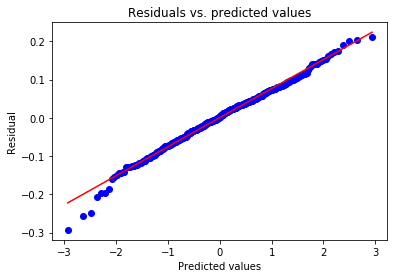

In [42]:
def resid_qq(y_train, y_test):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids, plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_train, y_test)   

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the straight line). This is particularly for large residuals.

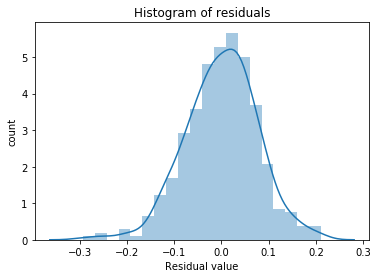

In [43]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score) 

This plot looks reasonable. The residual values are distributed near both sides of 0.

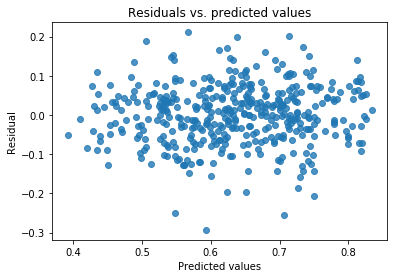

In [44]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score)

As expected, when plotting residuals we cannot see any clear pattern. Otherwise it would mean there is a hidden pattern we could not identify.

Consequently, we can conclude the model we have created will generalize well. 